# Intermittent time series

**VS Lumpy Timeseries**

là chuỗi thời gian không đều, đặc điểm chính:

<span style="color: green; font-size: 24px;">&#10004;</span> Giá trị xuất hiện không đều và có thể có những khoảng thời gian lâu dài giữa các lần xuất hiện

<span style="color: green; font-size: 24px;">&#10004;</span> Số lượng **Zero** lớn

<span style="color: green; font-size: 24px;">&#10004;</span> Không có **chu kỳ** rõ ràng

**Lumpy Timeseries**

👉 Xuất hiện đột ngột hơn

👉 Thường tập trung tại 1 điểm 

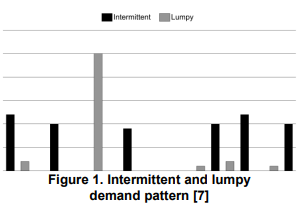

In [6]:
import pandas as pd
import numpy as np
import random
from datetime import datetime

In [27]:
df = pd.read_csv('..\Data\Verbr_2008_2021_sanitarisiert.txt',sep='\t')
df = df.T
df = df.iloc[:-1,:]

In [28]:
def convert_to_datetime(input_string):
    year = int(input_string[1:5])
    month = int(input_string[5:])

    result_datetime = datetime(year, month,1)

    return result_datetime

In [29]:
df.index = df.index.map(convert_to_datetime)

43647


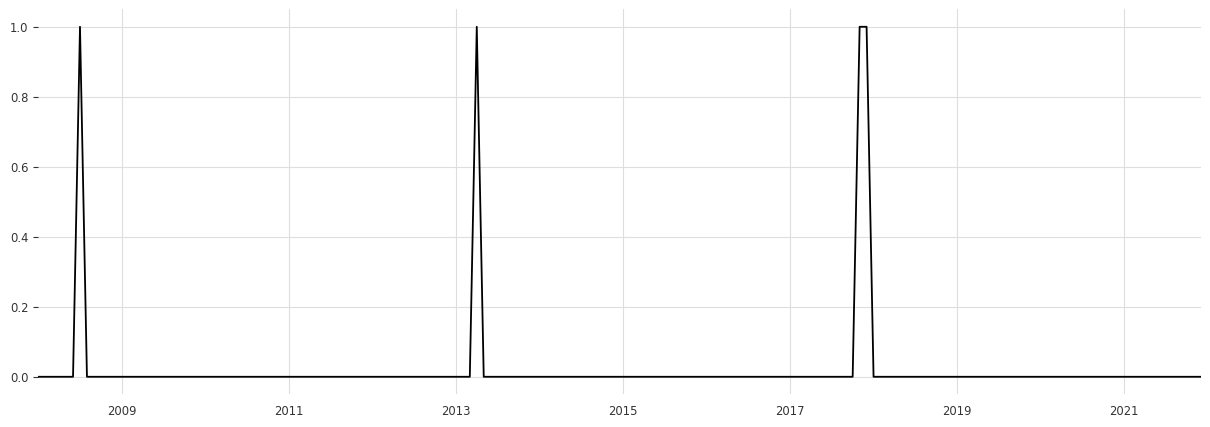

In [259]:
col = random.randint(1, 150810)
df.iloc[:,col].plot(figsize=(15,5))
print(col)

In [ ]:
col = random.randint(1, 150810)
df.iloc[:,col].plot(figsize=(15,5))
print(col)

# Croston

## Variable

### Demand level : z

là thành phần thể hiện sự xuất hiện của giá trị khác 0 trong chuỗi **d**

<span style="color: green; font-size: 24px;">&#10004;</span>Update(Simple Exponential Smoothing):

<font size=4 > If $ d_t > 0$, then $z_{t+1} = \alpha d_{t} + (1-\alpha)z_t$
   
<font size=4 >If $ d_t = 0$  👉 Forward fill missing values: $z_{t+1} = z_t$ 

với:
* z là giá trị dự đoán level
* d là giá trị thực tế level

### Periodicity : p

là chu kỳ hay khoảng cách xuất hiện demand

<span style="color: green; font-size: 24px;">&#10004;</span>Update(Simple Exponential Smoothing):

<font size=4 > If $ d_t > 0$, then $p_{t+1} = \alpha q + (1-\alpha)p_t$
    
<font size=4 >If $ d_t = 0$  👉 Forward fill missing values: $p_{t+1} = p_t$ 

với 
* p là giá trị dự đoán period
* q là giá trị thực tế period

## How it works?


<Axes: >

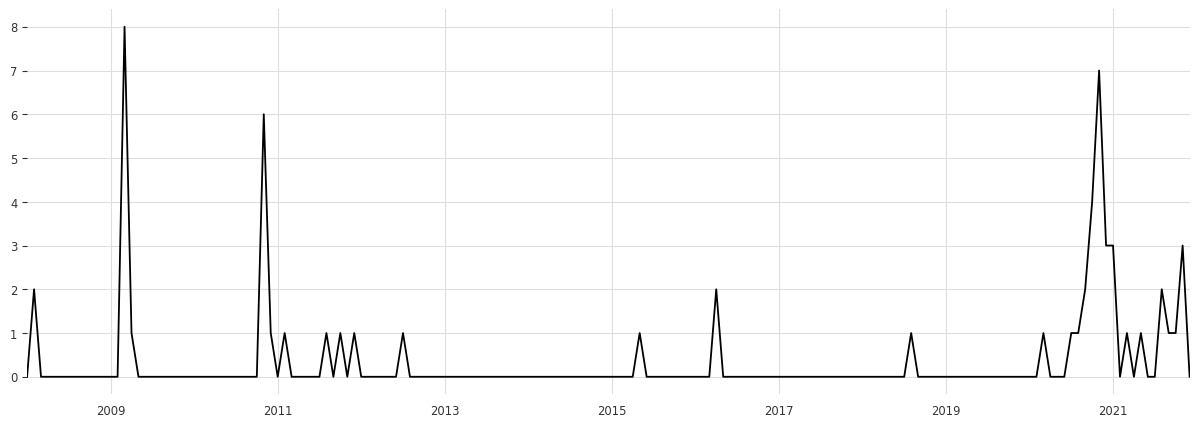

In [260]:
col = 112028
df.iloc[:,col].plot(figsize=(15,5))

In [308]:
ts = np.array(df.iloc[:,col])

<font size =5>**Step 1: Create a non-zero series or demand (z)**

In [309]:
z = ts[ts !=0]
z

array([2, 8, 1, 6, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 4, 7, 3, 3, 1,
       1, 2, 1, 1, 3], dtype=int64)

<font size=5> **Step 2: Create a series for the period (p)**

In [310]:
p_idx =np.flatnonzero(ts)
print('Index:',p_idx)
p = np.diff(p_idx,prepend=-1)
print('Period:',p)

Index: [  1  14  15  34  35  37  43  45  47  54  88  99 127 146 150 151 152 153
 154 155 156 158 160 163 164 165 166]
Period: [ 2 13  1 19  1  2  6  2  2  7 34 11 28 19  4  1  1  1  1  1  1  2  2  3
  1  1  1]


<font size=5> **Step 3: Perform Simple Exponential Smoothing**

In [432]:
alpha = 0.1
n = len(z)
z_hat = np.zeros(n)
p_hat = np.zeros(n)
z_hat[0] = z[0]
p_hat[0] = np.mean(p)

for i in range(1,n):
    z_hat[i] = alpha*z[i] + (1-alpha)*z_hat[i-1]
    p_hat[i] = alpha*p[i] + (1-alpha)*p_hat[i-1]
    
print('Smoothed Demand, z_hat: ', np.round(z_hat,2))
print('Smoothed Period, p_hat: ',np.round(p_hat,2))

Smoothed Demand, z_hat:  [2.   2.6  2.44 2.8  2.62 2.45 2.31 2.18 2.06 1.95 1.86 1.87 1.79 1.71
 1.64 1.57 1.62 1.85 2.37 2.43 2.49 2.34 2.21 2.19 2.07 1.96 2.06]
Smoothed Period, p_hat:  [ 6.19  6.87  6.28  7.55  6.9   6.41  6.37  5.93  5.54  5.68  8.51  8.76
 10.69 11.52 10.77  9.79  8.91  8.12  7.41  6.77  6.19  5.77  5.39  5.15
  4.74  4.37  4.03]


<font size=5> **Step 4: Calculate the forecast**

👉 Let dividing **z_hat** by **p_hat**

In [433]:
y_hat = z_hat / p_hat
print('Forecast: ', np.round(y_hat, 2))

Forecast:  [0.32 0.38 0.39 0.37 0.38 0.38 0.36 0.37 0.37 0.34 0.22 0.21 0.17 0.15
 0.15 0.16 0.18 0.23 0.32 0.36 0.4  0.41 0.41 0.42 0.44 0.45 0.51]


👉revert back to the original time index.

In [434]:
m = len(ts) 
forecast = np.empty(m)
forecast[:] = np.nan
forecast[p_idx+1] = y_hat

# Forward fill missing values with previous forecast
for i in range(1,m):
    if np.isnan(forecast[i]):
        forecast[i] = forecast[i-1]


👉 predict future

In [435]:
pred = z_hat[26]/p_hat[26]

pred_array = np.full(12, pred)

In [436]:
pred_array

array([0.51230924, 0.51230924, 0.51230924, 0.51230924, 0.51230924,
       0.51230924, 0.51230924, 0.51230924, 0.51230924, 0.51230924,
       0.51230924, 0.51230924])

👉 Plot

Text(0.5, 0, 'Time')

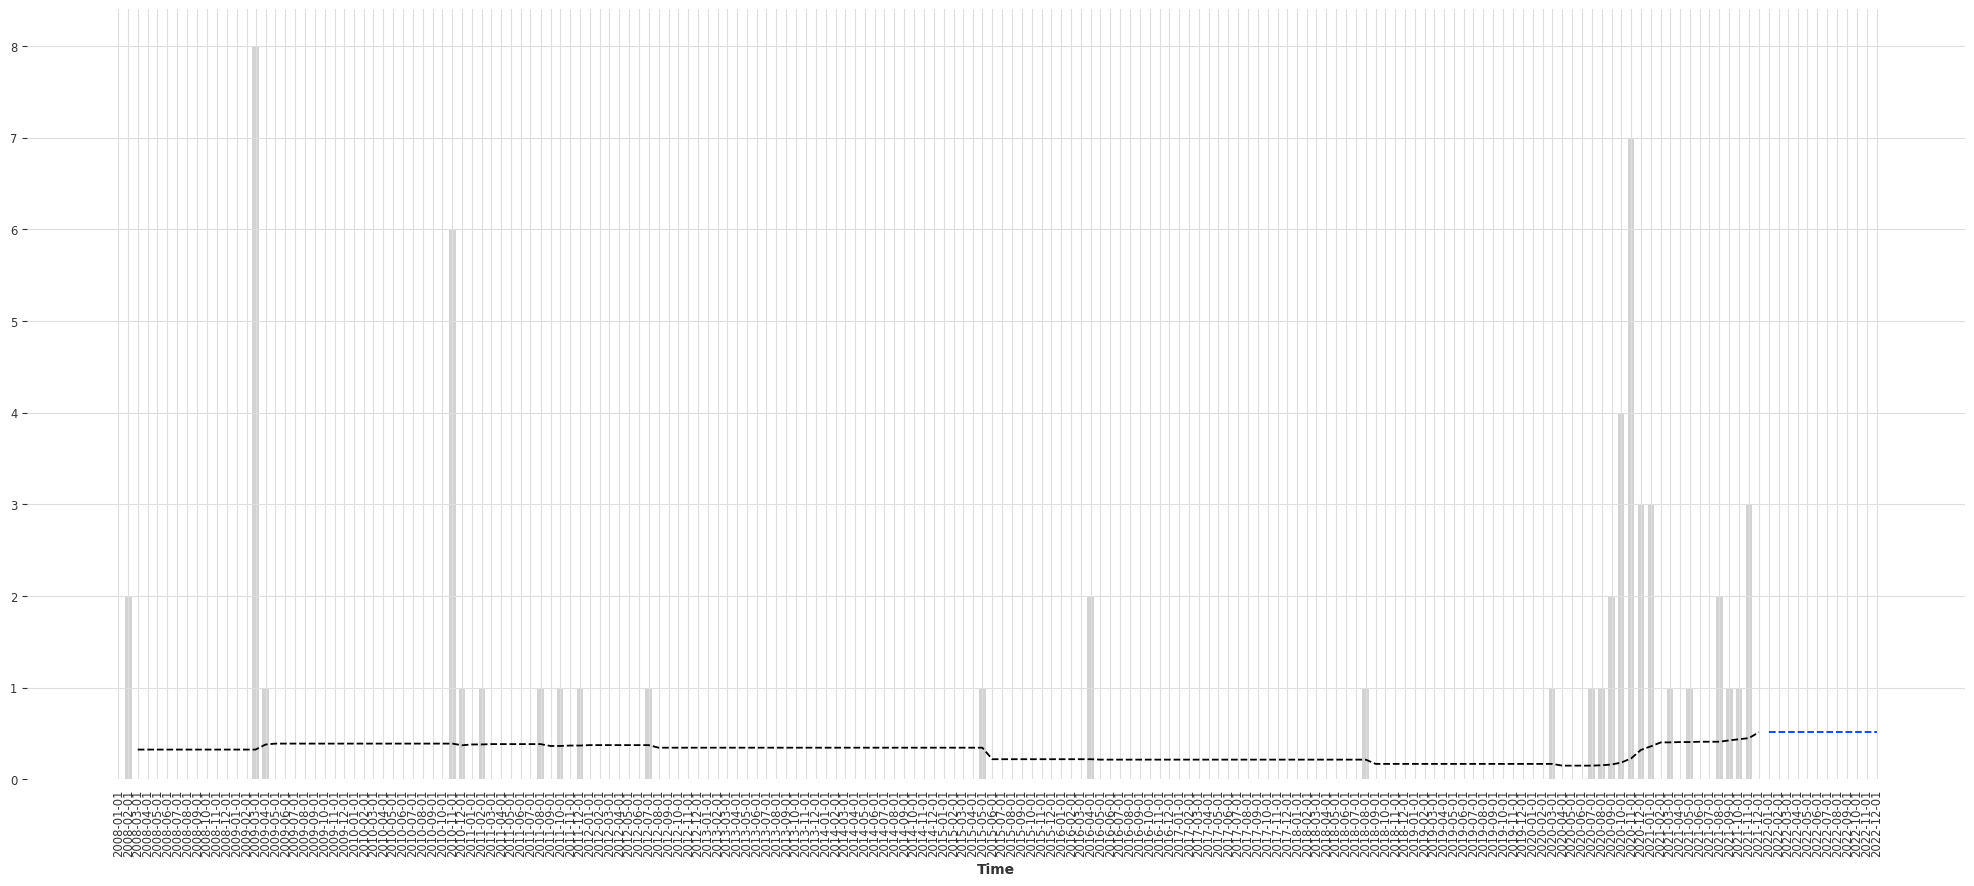

In [437]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25,10))
plt.bar(df.index, ts,color='lightgrey',width=20)
plt.plot(df.index, forecast, linestyle='--', label='Forecast')
plt.plot(np.arange('2022-01-01','2023-01-01',dtype='datetime64[M]'), pred_array, linestyle='--', label='Forecast')
plt.xticks(np.arange('2008-01-01','2023-01-01',dtype='datetime64[M]'),rotation=90)
plt.xlabel('Time')

## Compare

### Darts library vs Custom

In [28]:
ts = np.array(df.iloc[:,112028])
ts

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 4,
       7, 3, 3, 0, 1, 0, 1, 0, 0, 2, 1, 1, 3, 0], dtype=int64)

In [29]:
ts.shape

(168,)

In [31]:
from darts.models import Croston
from darts import TimeSeries

In [32]:
series = TimeSeries.from_values(ts)


model = Croston(version='classic')
model.fit(series)
pred_series = model.predict(12)

ValueError: operands could not be broadcast together with shapes (168,) (27,) 

In [39]:
series = TimeSeries.from_values(ts)


model = Croston(series,alpha=0.1)
model.fit(series)
pred_series = model.predict(12)

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

Text(0.5, 0, 'Time')

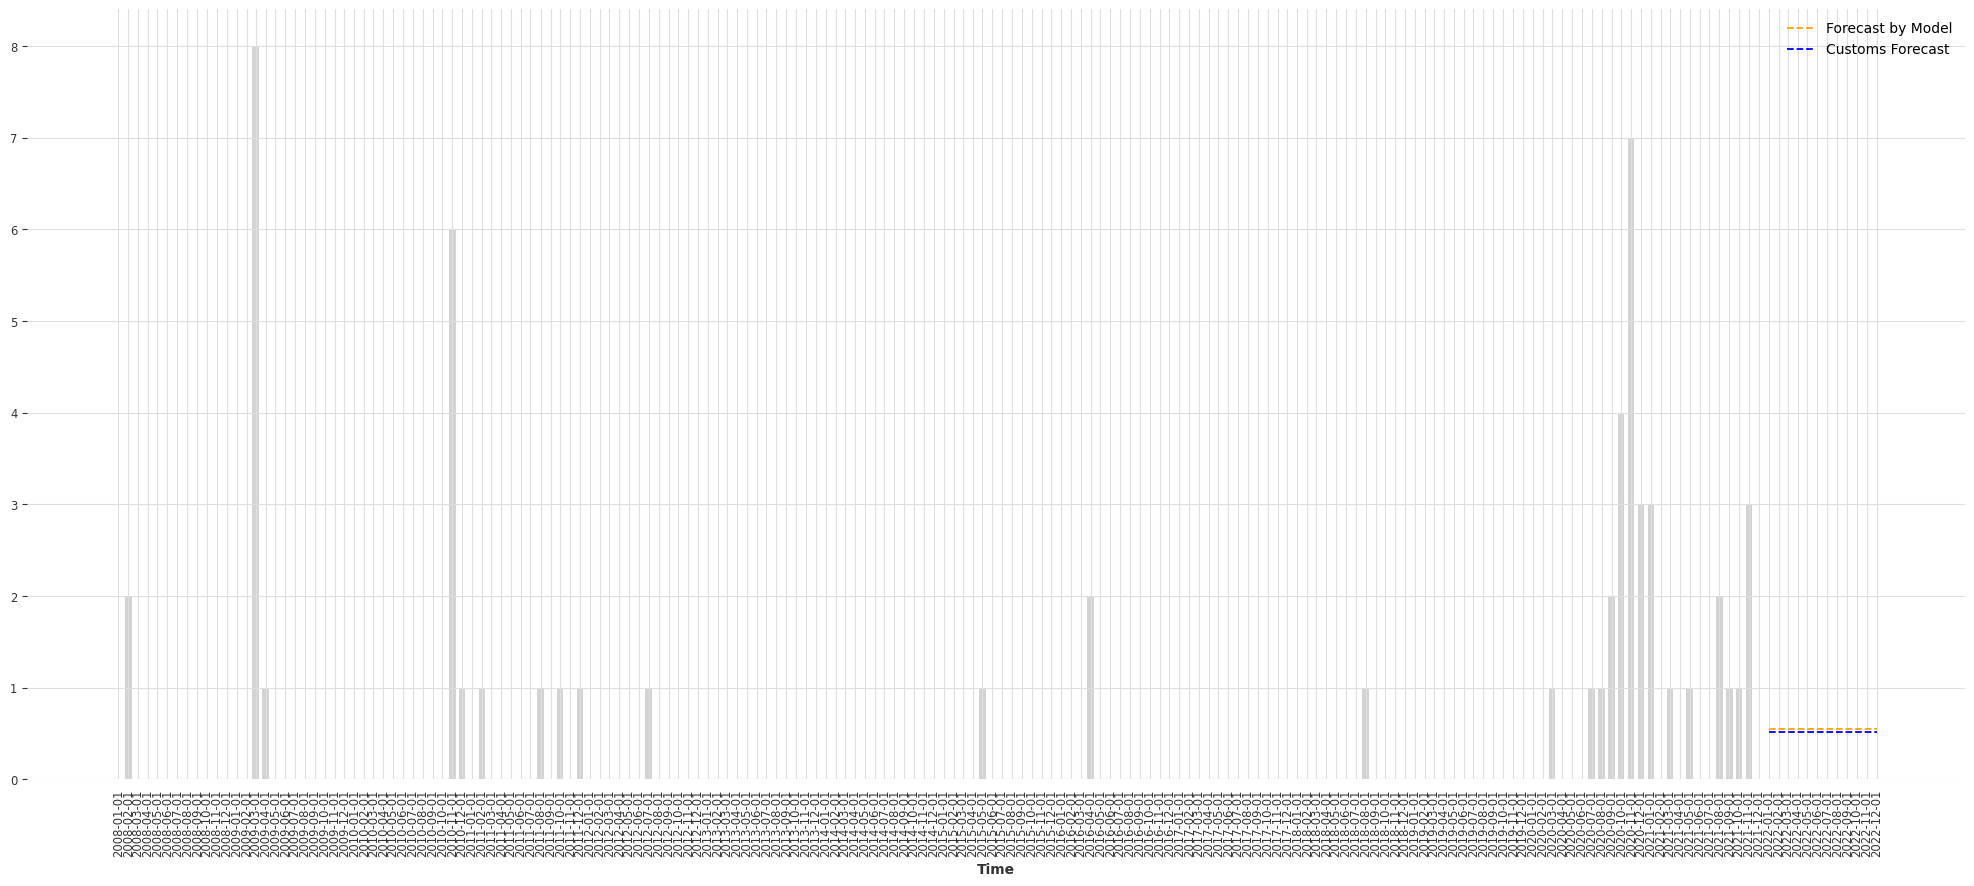

In [415]:
fig, ax = plt.subplots(figsize=(25,10))

plt.bar(df.index, ts,color='lightgrey',width=20)

plt.plot(np.arange('2022-01-01','2023-01-01',dtype='datetime64[M]')
         , pred_series.values(), linestyle='--', label='Forecast by Model',color='orange')

plt.plot(np.arange('2022-01-01','2023-01-01',dtype='datetime64[M]')
         , pred_array, linestyle='--', label='Customs Forecast',color='blue')


plt.xticks(np.arange('2008-01-01','2023-01-01',dtype='datetime64[M]'),rotation=90)
# plt.xticks(np.arange('2022-01-01','2023-01-01',dtype='datetime64[M]'),rotation=90)
plt.legend()
plt.xlabel('Time')

### Croston library vs Custom

👉 Custom

In [441]:
alpha = 0.9
n = len(z)
z_hat = np.zeros(n)
p_hat = np.zeros(n)
z_hat[0] = z[0]
p_hat[0] = np.mean(p)



z = ts[ts !=0]
p_idx =np.flatnonzero(ts)
p = np.diff(p_idx,prepend=-1)
for i in range(1,n):
    z_hat[i] = alpha*z[i] + (1-alpha)*z_hat[i-1]
    p_hat[i] = alpha*p[i] + (1-alpha)*p_hat[i-1]
y_hat = z_hat / p_hat
m = len(ts) 
forecast_9 = np.empty(m)
forecast_9[:] = np.nan
forecast_9[p_idx+1] = y_hat

for i in range(1,m):
    if np.isnan(forecast_9[i]):
        forecast_9[i] = forecast_9[i-1]


👉 Croston library

In [416]:
fit_pred = croston.fit_croston(ts, 12,'original')
yhat = np.concatenate([fit_pred['croston_fittedvalues'], fit_pred['croston_forecast']])

Text(0.5, 0, 'Time')

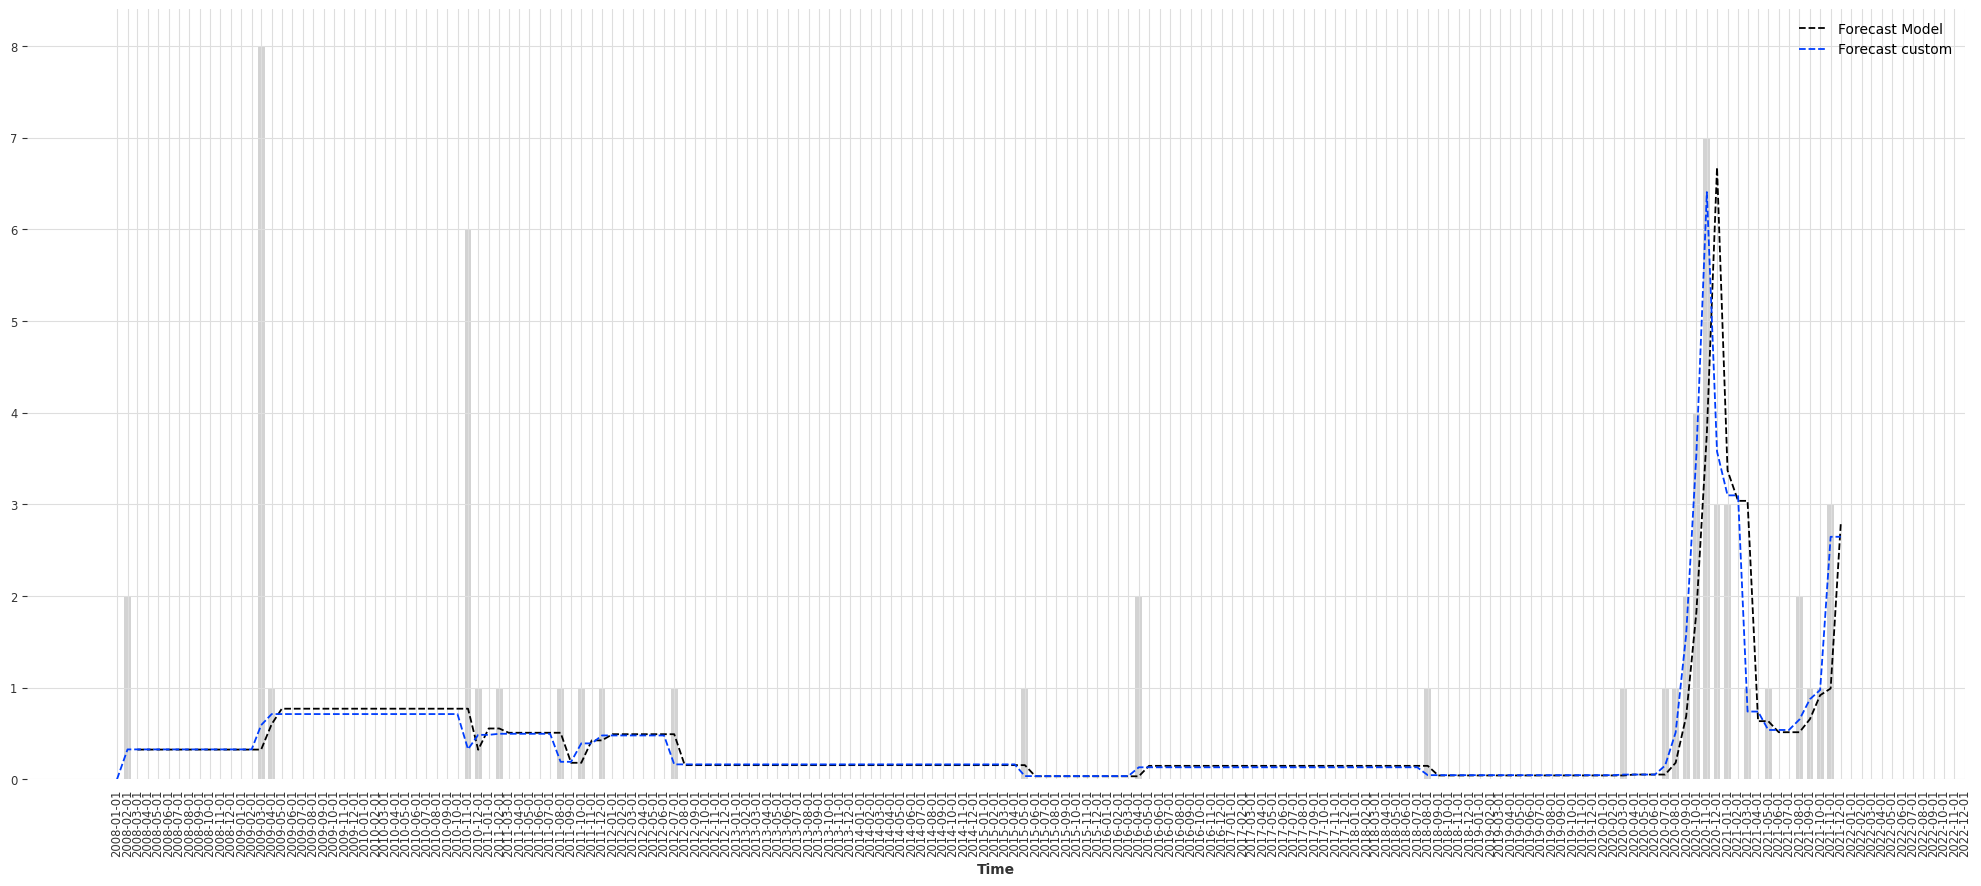

In [442]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25,10))
plt.bar(df.index, ts,color='lightgrey',width=20)
plt.plot(df.index, forecast_9, linestyle='--', label='Forecast Model')
plt.plot(df.index, yhat[:168], linestyle='--', label='Forecast custom')
plt.xticks(np.arange('2008-01-01','2023-01-01',dtype='datetime64[M]'),rotation=90)
plt.legend()
plt.xlabel('Time')

### Sktime library

# TSB model

là biến thể của Croston

## Variable

### Demand level: z

Giữ cách tính `Demand level` của Croston

### Periodicity: p

thể hiện rõ hơn sự xuất hiện hay không của **Demand**:
* Giảm, nếu không có **Demand**
* Tăng, ngược lại

<span style="color: green; font-size: 24px;">&#10004;</span>Update:

<font size=5> if $d_t >0$ then $p_{t+1} = \beta + (1-\beta)p_t$

<font size=5> if $d_t = 0$ then $p_{t+1} = (1-\beta)p_t $

### ⚠️ Forecast:

Công thức tính Forecast (f) là **nhân**:

<font size=5> $f_{t+1} = p_{t+1}a_{t+1} $

# Apply model

http://localhost:8888/notebooks/Time%20Series/Apply%20Croston%20and%20TSB.ipynb

# Report

**3 Types of models:**
* Statistic
* Machine Learning
* Deep Learning

**2 Metrics:**
* SPEC
* MASE


👉 **Low intermittence and low lumpiness** data

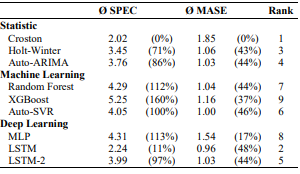

👉 **Intermittent** data

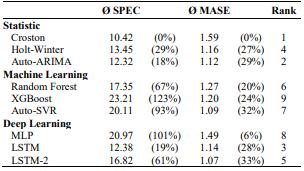

👉 **Lumpy** data

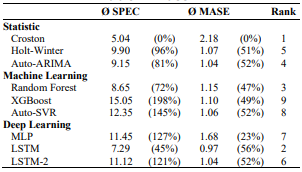

👉 Consists of **Intermittent** and **Lumpy** time series

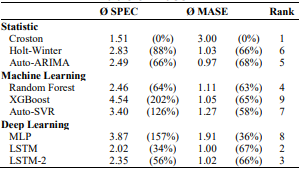

<font size=4>👉 Conclusion

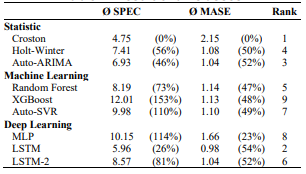

* The **statistical methods** thus dominate the upper ranks compared to the other methods.
* The deep learning methods perform better on average with the SPEC metric than the machine learning methods

# Emoji


<span style="color:red">&#10060;</span> : X

👉 👇


⚠️

<span style="color: green; font-size: 24px;">&#10004;</span>
: Dấu tích

&#128161; : bóng đèn

<font size =5> &#x1F9EE; Công thức 

<font size =5> &#x1F4DA; : Bài tập
   
<img src='link' style="width:500px;"/> : Chèn ảnh
    
<div style="margin-left: 200px;">: căn lề
    
<span style="color: red;"> Chữ_màu</span>

In [105]:
1.63*796/60

21.624666666666666